### Exploration of the most funny and the less funny caption

#### Data importation


In [2]:
import pandas as pd
import numpy as n
import pickle
import re
from pathlib import Path
import sys


root = Path(__file__).resolve().parent if "__file__" in globals() else Path.cwd()
while root.parent != root:
    if ((root / ".git").exists() and 
        (root / "README.txt").exists() and 
        (root / "results.ipynb").exists()): break
    root = root.parent
if str(root) not in sys.path: sys.path.insert(0, str(root))

print("Root folder at: ", root)

from src.utils.paths import *

stored_dataprep_pkl_path = root / STORED_DATAPREP_PKL_PATH
with open(stored_dataprep_pkl_path, "rb") as f:
    data = pickle.load(f)


Root folder at:  /Users/todorovkatia/Documents/EPFL/MA3/ADA/Projet/ada-2025-project-adacore42


In [34]:
dataA = data['dataA']
# dataC est un DataFrame de métadonnées de tous les cartoon contests.
dataC = data['dataC']
dataA_startID = data['dataA_startID']
dataA_endID = data['dataA_endID']
dataC_lastGoodID = data['dataC_lastGoodID']

display(dataA[0])



,caption,mean,precision,votes,not_funny,somewhat_funny,funny,funny_over_unfunny,funny_over_total,unfunny_over_total
rank,,,,,,,,,,
0,I'm a congressman--obstruction is my job.,1.913043,0.094022,69,24,27,18,0.750000,0.260870,0.347826
1,"I'm what they mean when they say, 'The middle ...",1.842105,0.191381,19,8,6,5,0.625000,0.263158,0.421053
2,Does this suit make me look flat?,1.711111,0.112915,45,21,16,8,0.380952,0.177778,0.466667
3,"When the right woman comes along, I'll know it.",1.625000,0.116657,32,15,14,3,0.200000,0.093750,0.468750
4,"I used to lie in the gutter, but then I quit d...",1.617647,0.133610,34,19,9,6,0.315789,0.176471,0.558824
...,...,...,...,...,...,...,...,...,...,...
3900,"Just getting material for my book, "" Humanity ...",1.000000,0.117851,9,9,0,0,0.000000,0.000000,1.000000
3901,This has 'Alice in Wonderland' beat by a mile.,1.000000,0.117851,9,9,0,0,0.000000,0.000000,1.000000
3902,I could use a quick pick-me-up.,1.000000,0.117851,9,9,0,0,0.000000,0.000000,1.000000


In [16]:
def add_funny_ratios(df):
    """
    Adds ratio columns based on 'Funny' and 'Not funny' columns.
    """
   
    
    df['funny_over_unfunny'] = n.where(df['not_funny'] != 0, df['funny'] / df['not_funny'], n.nan)
    df['funny_over_total'] = n.where(df['votes'] != 0, df['funny'] / df['votes'], n.nan)
    df['unfunny_over_total'] = n.where(df['votes'] != 0, df['not_funny'] / df['votes'], n.nan)
    
    return df

# Apply the function to every DataFrame in your list
dataA = [add_funny_ratios(df) for df in dataA]

#### Show number of votes per caption

In [17]:
dataA[0]

,caption,mean,precision,votes,not_funny,somewhat_funny,funny,funny_over_unfunny,funny_over_total,unfunny_over_total
rank,,,,,,,,,,
0,I'm a congressman--obstruction is my job.,1.913043,0.094022,69,24,27,18,0.750000,0.260870,0.347826
1,"I'm what they mean when they say, 'The middle ...",1.842105,0.191381,19,8,6,5,0.625000,0.263158,0.421053
2,Does this suit make me look flat?,1.711111,0.112915,45,21,16,8,0.380952,0.177778,0.466667
3,"When the right woman comes along, I'll know it.",1.625000,0.116657,32,15,14,3,0.200000,0.093750,0.468750
4,"I used to lie in the gutter, but then I quit d...",1.617647,0.133610,34,19,9,6,0.315789,0.176471,0.558824
...,...,...,...,...,...,...,...,...,...,...
3900,"Just getting material for my book, "" Humanity ...",1.000000,0.117851,9,9,0,0,0.000000,0.000000,1.000000
3901,This has 'Alice in Wonderland' beat by a mile.,1.000000,0.117851,9,9,0,0,0.000000,0.000000,1.000000
3902,I could use a quick pick-me-up.,1.000000,0.117851,9,9,0,0,0.000000,0.000000,1.000000


#### Find most funny and most unfunny

In [32]:

def find_best_and_worth(dataA, var1, var2):
    """ var 1 is funny and var 2 should be unfunny """
    max_funny_value = float('-inf')
    max_funny_row = None
    max_funny_df_index = None
    max_funny_idx_in_df = None

    max_not_funny_value = float('-inf')
    max_not_funny_row = None
    max_not_funny_df_index = None
    max_not_funny_idx_in_df = None
    
    # Boucle sur tous les DataFrames
    for i, df in enumerate(dataA):
        if var1 in df.columns and var2 in df.columns:

            # Max de Funny
            if not df[var1].empty:
                idx_max_funny = df[var1].idxmax()
                if df.loc[idx_max_funny, var1] > max_funny_value:
                    max_funny_value = df.loc[idx_max_funny, var1]
                    max_funny_row = df.loc[idx_max_funny]
                    max_funny_df_index = i
                    max_funny_idx_in_df = idx_max_funny

            # Max de Not funny
            if not df[var2].empty:
                idx_max_not_funny = df[var2].idxmax()
                if df.loc[idx_max_not_funny, var2] > max_not_funny_value:
                    max_not_funny_value = df.loc[idx_max_not_funny, var2]
                    max_not_funny_row = df.loc[idx_max_not_funny]
                    max_not_funny_df_index = i
                    max_not_funny_idx_in_df = idx_max_not_funny

    print("---- Résultat ----")
    print(f"Max {var1} : valeur {max_funny_value} trouvée dans df[{max_funny_df_index+dataA_startID}] - Index is df {max_funny_df_index} and ligne index {max_funny_idx_in_df}")
    print(max_funny_row)
    print("\n")
    print(f"Max {var2}: valeur {max_not_funny_value} trouvée dans df[{max_not_funny_df_index+dataA_startID}]- Index is df {max_not_funny_df_index} and ligne index {max_not_funny_idx_in_df}")
    print(max_not_funny_row)    



In [33]:
find_best_and_worst(dataA,'funny_over_total','unfunny_over_total')

---- Résultat ----
Max funny_over_total : valeur 0.9989177489177489 trouvée dans df[88], ligne index 0
caption               Mission accomplished. We will report that this...
mean                                                           2.998918
precision                                                      0.001083
votes                                                               924
not_funny                                                             0
somewhat_funny                                                        1
funny                                                               923
funny_over_unfunny                                                  NaN
funny_over_total                                               0.998918
unfunny_over_total                                                  0.0
Name: 0, dtype: object


Max unfunny_over_total: valeur 1.0 trouvée dans df[0], ligne index 1987
caption               That's right, just walk all over me. You would...
mean    

#### Explore ratio funny-unfunny caption per images

The following plot shows that for all caption, there is only a few caption that are considered funny while a big number are considered not funny, this is shown by the ratio btw funny (mean >2) and unfunny (mean <1.5) captions for a same image.

In [ ]:
ratios = []  # Pour stocker le ratio de chaque DataFrame

for i,df in enumerate(dataA):
    # Vérifie que les colonnes existent
    
    nb_droles = (df['mean'] > 2).sum()
    nb_pas_droles = (df['mean'] < 1.5).sum()

        
    ratio = nb_droles / nb_pas_droles if nb_pas_droles != 0 else n.nan # Eviter division par zéro
    #ratios.append(ratio)
    ratios.append((i, ratio)) 


<Axes: >

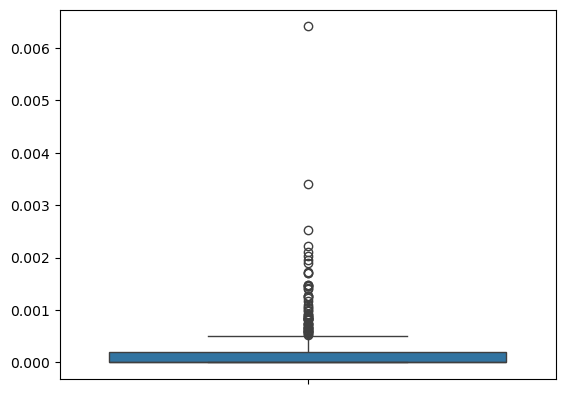

In [52]:
import seaborn as sns 
ratio_values = [r for i, r in ratios if not n.isnan(r)]

sns.boxplot(ratio_values)

In [53]:

best_df_index, best_ratio = max(ratios, key=lambda x: x[1])
print("\n📊 Le DataFrame avec le plus grand ratio est :")
print(f"➡️ df[{best_df_index}] avec un ratio drôle/pas drôle de {best_ratio}")


📊 Le DataFrame avec le plus grand ratio est :
➡️ df[88] avec un ratio drôle/pas drôle de 0.00641025641025641


In [54]:
88+510

598